# Imports

In [25]:
!ls /content/gdrive/'My Drive'/collab_files/training_1/
#!touch /content/gdrive/'My Drive'/collab_files/training_1/a

a


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
import pprint
from google.colab import drive

print(tf.__version__)


1.15.0


Using TensorFlow backend.


In [0]:
gdrive_path = "/content/gdrive"
drive.mount(gdrive_path)
model_persistence_path = gdrive_path + "/'My Drive'/collab_files/model.h5"
checkpoint_path = gdrive_path + "/'My Drive'/collab_files/training_1/"


In [2]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.100.72.178:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.100.72.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4242706830064829609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8337965078701333332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16927502114099096915)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 414390626780766228)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/devi

# Variables

In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Download Trainingsdata

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(validation_dir)

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures


68608000/68606236 [==============================] - 0s 0us/step
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
#datagen = ImageDataGenerator(
# rotation_range=20,
# width_shift_range=0.2,
# height_shift_range=0.2,
# horizontal_flip=True,
# zoom_range=0.5)
datagen = ImageDataGenerator(
 #rotation_range=20,
 #width_shift_range=0.2,
 #height_shift_range=0.2,
 horizontal_flip=True
 #zoom_range=0.5
 )

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

print("[INFO] generating trainings_data ...")
train_data_gen = datagen.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     color_mode="rgb",
                                                     #class_mode="categorical")
                                                     class_mode="sparse")
print("[INFO] generating trainings_data completed")

print("[INFO] generating validation data ...")
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode="rgb",
                                                              #class_mode="categorical")
                                                              class_mode="sparse")
print("[INFO] generating validation data completed")


total_train = train_data_gen.samples
total_val = val_data_gen.samples
class_names = {v: k for k, v in train_data_gen.class_indices.items()}

print("[INFO] Trainings and Validation Data generation completed")


[INFO] generating trainings_data ...
Found 2000 images belonging to 2 classes.
[INFO] generating trainings_data completed
[INFO] generating validation data ...
Found 1000 images belonging to 2 classes.
[INFO] generating validation data completed
[INFO] Trainings and Validation Data generation completed


# Show of traininings data

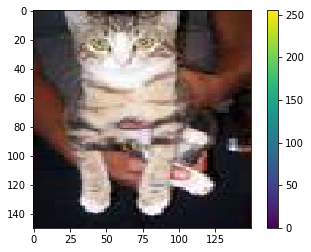

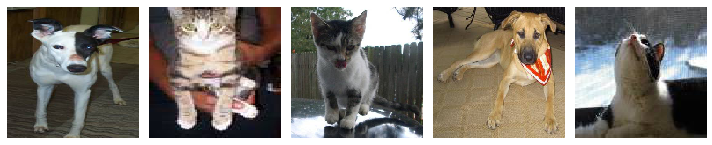

In [6]:
sample_training_images, _ = next(train_data_gen)

plt.figure()
plt.imshow(sample_training_images[1].astype('uint8'))

plt.colorbar()
plt.grid(False)
plt.show()

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

# Model declaration

In [7]:
model = tf.keras.Sequential(
  [
    tf.keras.layers.Reshape(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), target_shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="image"),

    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)), # no bias necessary before batch norm
    #tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
    tf.keras.layers.Activation('relu'), # activation after batch norm

    #tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    #tf.keras.layers.BatchNormalization(scale=False, center=True),
    #tf.keras.layers.Activation('relu'),

    #tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
    #tf.keras.layers.BatchNormalization(scale=False, center=True),
    #tf.keras.layers.Activation('relu'),

    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(200, use_bias=False),
    #tf.keras.layers.BatchNormalization(scale=False, center=True),
    #tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

    tf.keras.layers.Dense(2, activation='softmax')
  ])

#model = Sequential([
#    Conv2D(16, 3, padding='same', activation='relu', 
#           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#    MaxPooling2D(),
#    Dropout(0.2),
#    Conv2D(32, 3, padding='same', activation='relu'),
#    MaxPooling2D(),
#    Conv2D(64, 3, padding='same', activation='relu'),
#    MaxPooling2D(),
#    Dropout(0.2),
#    Flatten(),
#    Dense(512, activation='relu'),
#    Dense(len(val_data_gen.class_indices), activation='sigmoid')
#])

#model = keras.Sequential([
#    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH)),
#    keras.layers.Dense(128, activation='relu'),
#    keras.layers.Dense(10, activation='softmax')
#])
model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
#opt = RMSprop(lr=0.0001, decay=1e-6)
#model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

print("[INFO] Model compiled")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[INFO] Model compiled


# Persistence of the model

In [0]:
def show_model_history(histoy,epochs):
  acc = history.history['acc']
  loss = history.history['loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Model Training

In [11]:
#if os.path.isfile(model_persistence_path):
#  print("[INFO] model is persisted")
#  model = keras.models.load_model(model_persistence_path)
#  print("[INFO] model loaded.")
#else:
#  print("[INFO] model is not  persisted")
#  print("Options:")
#  print( "steps_per_epoch = " +str(total_train // batch_size))
#  print("epochs = " + str(epochs))
#  print("validation_steps = "+str(total_val // batch_size))
#  print("=========================")

  #p_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 #save_weights_only=True,
                                                #verbose=1)
#history = model.fit_generator(
#    train_data_gen,
#    steps_per_epoch=total_train // batch_size,
#    epochs=epochs,
#    validation_data=val_data_gen,
#    validation_steps=total_val // batch_size
#      #callbacks=[cp_callback]
#  )
  #model.save(model_persistence_path,overwrite=True)
print("[INFO] model trained.")

#latest = tf.train.latest_checkpoint(checkpoint_dir)
#model = create_model()
#model.load_weights(latest)
#loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))


show_model_history(history,epochs)


INFO:tensorflow:Querying Tensorflow master (grpc://10.100.72.178:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4242706830064829609)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8337965078701333332)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16927502114099096915)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 414390626780766228)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16210548090763639294)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:wor

FailedPreconditionError: ignored

# Predict images

nr 91 is a cats
[0.5041671  0.49583295]


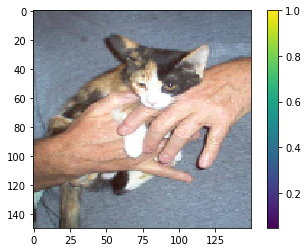

nr 89 is a cats
[0.5013564 0.4986436]


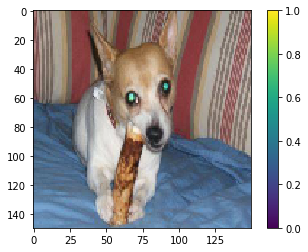

nr 1 is a dogs
[0.48742637 0.51257366]


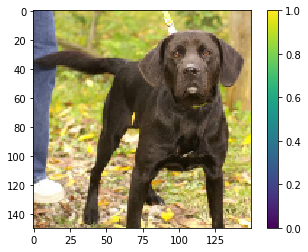

nr 1 is a dogs
[0.48742637 0.51257366]


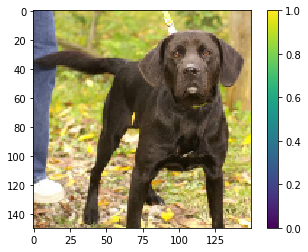

nr 27 is a dogs
[0.4975137 0.5024862]


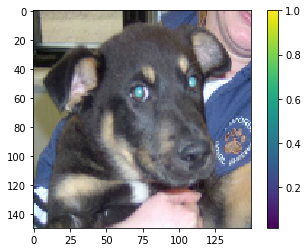

nr 82 is a cats
[0.5575424  0.44245762]


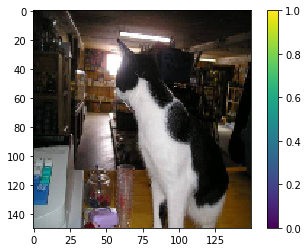

In [0]:

sample_training_images, _ = next(val_data_gen)
predictions = model.predict(sample_training_images)
for a in range(6):
  nu = random.randint(0, len(sample_training_images))
  print("nr "+str(nu) + " is a " + class_names[np.argmax(predictions[nu])])
  print(predictions[nu])
  plt.figure()
  #plt.imshow(sample_training_images[nu].astype('uint8'))
  plt.imshow(sample_training_images[nu])
  plt.colorbar()
  plt.grid(False)
  plt.show()
  


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
